#1b) Classificatore multiclass (5 classes)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/bbc-data.csv

--2022-04-25 07:51:35--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/bbc-data.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.50
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3351206 (3.2M) [text/csv]
Saving to: ‘bbc-data.csv’

bbc-data.csv        100%[===================>]   3.20M  3.35MB/s    in 1.0s    

2022-04-25 07:51:36 (3.35 MB/s) - ‘bbc-data.csv’ saved [3351206/3351206]



In [4]:
df = pd.read_csv('bbc-data.csv') 
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [5]:
df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

###Data cleaning

In [6]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [7]:
#Applichiamo la funzione di cleaning all in once
df["Text"] = df["Text"].apply(clean_special_patterns)
df

,ArticleId,Text,Category
0,1833,worldcom ex boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens inm...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses inpayout eighteen former enron di...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [33]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

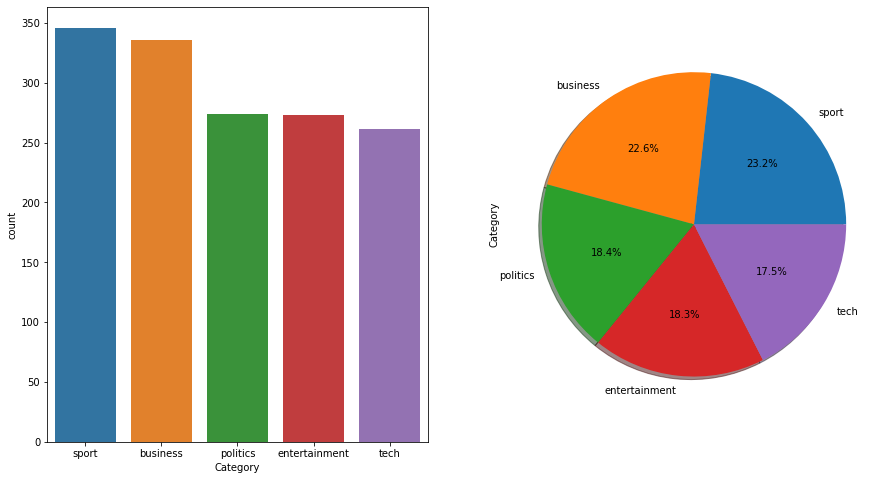

In [35]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
sns.countplot(x='Category',data=df,order = df['Category'].value_counts().index,ax=ax[0])
df["Category"].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1], shadow = True)

In [36]:
df["Category"] = df["Category"].replace({'sport':0,'business':1,"politics":2,"entertainment":3,"tech":4})
df = df[['Text','Category']]
df

,Text,Category
0,worldcom ex boss launches defence lawyers defe...,1
1,german business confidence slides german busin...,1
2,bbc poll indicates economic gloom citizens inm...,1
3,lifestyle governs mobile choice faster better ...,4
4,enron bosses inpayout eighteen former enron di...,1
...,...,...
1485,double eviction from big brother model caprice...,3
1486,dj double act revamp chart show dj duo jk and ...,3
1487,weak dollar hits reuters revenues at media gro...,1
1488,apple ipod family expands market apple has exp...,4


### STOPWORDS + LEMMATIZATION Function with SpaCy

In [ ]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [ ]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df["Text"] = df["Text"].apply(text_preprocess)
df

,Text,Category
0,worldcom ex boss launch defence lawyer defend ...,1
1,german business confidence slide german busine...,1
2,bbc poll indicate economic gloom citizen inmaj...,1
3,lifestyle govern mobile choice faster well fun...,4
4,enron boss inpayout eighteen enron director ag...,1
...,...,...
1485,double eviction big brother model caprice holb...,3
1486,dj double act revamp chart dj duo jk joel take...,3
1487,weak dollar hit reuters revenue medium group r...,1
1488,apple ipod family expand market apple expand i...,4


### EDA

In [ ]:
cleaned = ' '.join(df['Text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

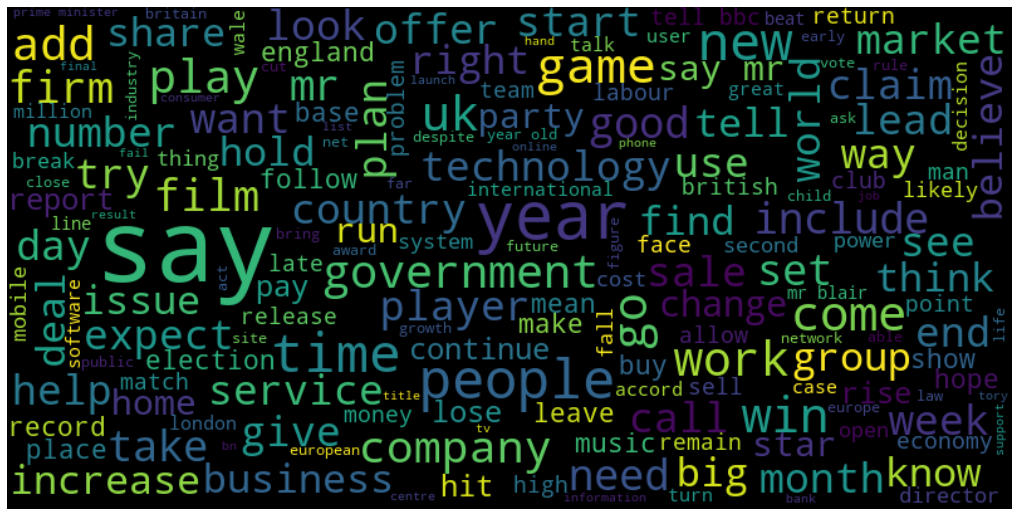

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

### Bag of Words

In [ ]:
X = df['Text'] # FEATURES
y = df['Category'] # TARGET

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

### SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [ ]:
labels = ['sport','business',"politics","entertainment","tech"]

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

In [ ]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.903485254691689


Text(69.0, 0.5, 'Actual')

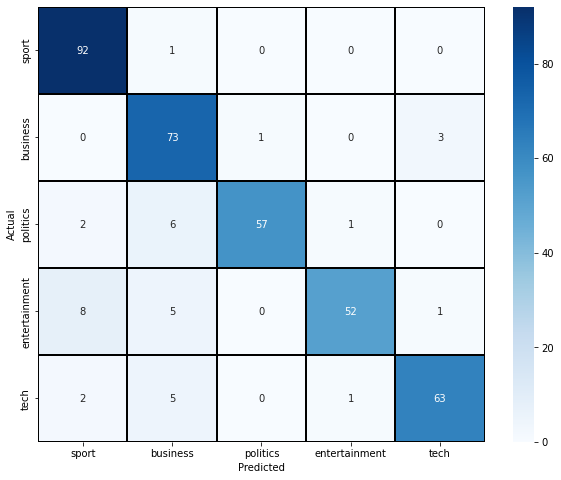

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

        sport       0.88      0.99      0.93        93
     business       0.81      0.95      0.87        77
     politics       0.98      0.86      0.92        66
entertainment       0.96      0.79      0.87        66
         tech       0.94      0.89      0.91        71

     accuracy                           0.90       373
    macro avg       0.92      0.90      0.90       373
 weighted avg       0.91      0.90      0.90       373



### Multinomial NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train) 

MultinomialNB()

In [ ]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9731903485254692


Text(69.0, 0.5, 'Actual')

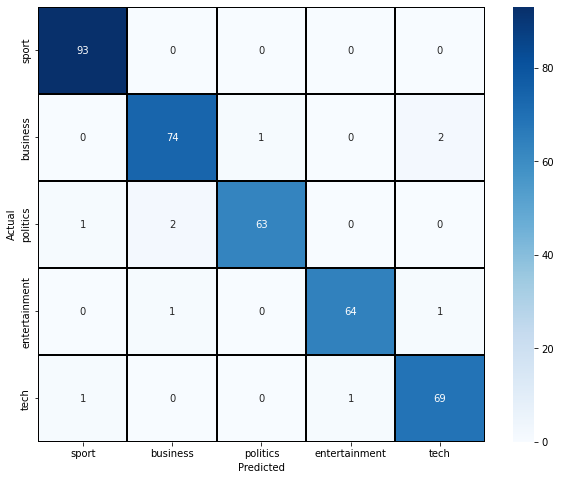

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

        sport       0.98      1.00      0.99        93
     business       0.96      0.96      0.96        77
     politics       0.98      0.95      0.97        66
entertainment       0.98      0.97      0.98        66
         tech       0.96      0.97      0.97        71

     accuracy                           0.97       373
    macro avg       0.97      0.97      0.97       373
 weighted avg       0.97      0.97      0.97       373



### SGD Classifier

In [ ]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9624664879356568


Text(69.0, 0.5, 'Actual')

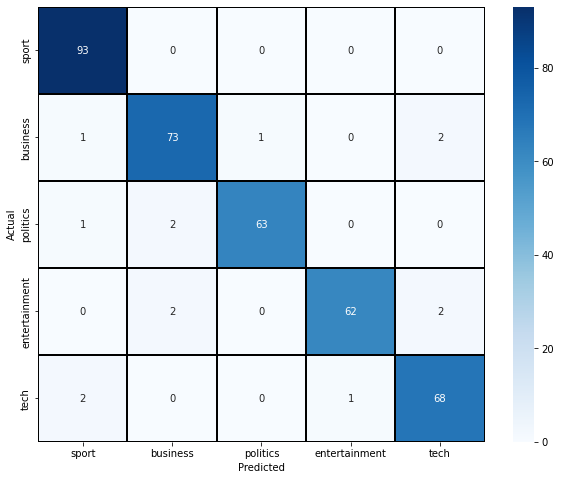

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

        sport       0.96      1.00      0.98        93
     business       0.95      0.95      0.95        77
     politics       0.98      0.95      0.97        66
entertainment       0.98      0.94      0.96        66
         tech       0.94      0.96      0.95        71

     accuracy                           0.96       373
    macro avg       0.96      0.96      0.96       373
 weighted avg       0.96      0.96      0.96       373



### Pipeline

In [ ]:
# X = features raw on text format
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [ ]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(y_test,predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9705093833780161


In [ ]:
test = pd.Series({'Text':'football'})

In [ ]:
# 'sport':0,'business':1,"politics":2,"entertainment":3,"tech":4

In [ ]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('sport')
elif (prediction[0] == 1):
  print('business')
elif (prediction[0] == 2):
  print('politics')
elif (prediction[0] == 3):
  print('entertinment')
else:
  print('tech')

0
sport


In [ ]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

#2b) Classificatore binario sport & business

In [ ]:
# 'sport':0,'business':1,"politics":2,"entertainment":3,"tech":4

In [ ]:
df

,Text,Category
0,worldcom ex boss launch defence lawyer defend ...,1
1,german business confidence slide german busine...,1
2,bbc poll indicate economic gloom citizen inmaj...,1
3,lifestyle govern mobile choice faster well fun...,4
4,enron boss inpayout eighteen enron director ag...,1
...,...,...
1485,double eviction big brother model caprice holb...,3
1486,dj double act revamp chart dj duo jk joel take...,3
1487,weak dollar hit reuters revenue medium group r...,1
1488,apple ipod family expand market apple expand i...,4


In [ ]:
df.drop(df.loc[df['Category']>1].index, inplace=True)

In [ ]:
df

### EDA

In [ ]:
cleaned = ' '.join(df['Text'].to_list())

(-0.5, 799.5, 399.5, -0.5)

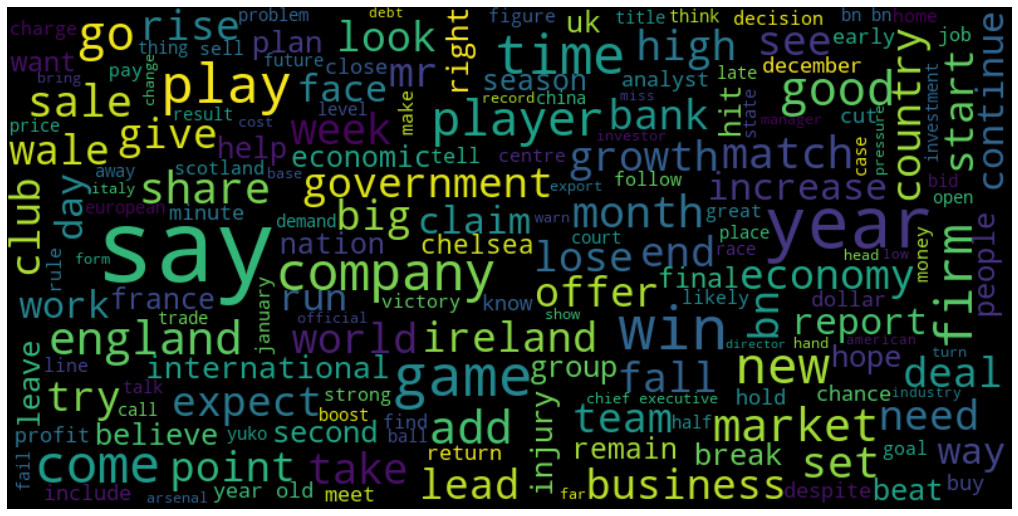

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [ ]:
X = df['Text'] # FEATURES
y = df['Category'] # TARGET

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [ ]:
labels = ['sport','business']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train) 

MultinomialNB()

In [ ]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  1.0


Text(69.0, 0.5, 'Actual')

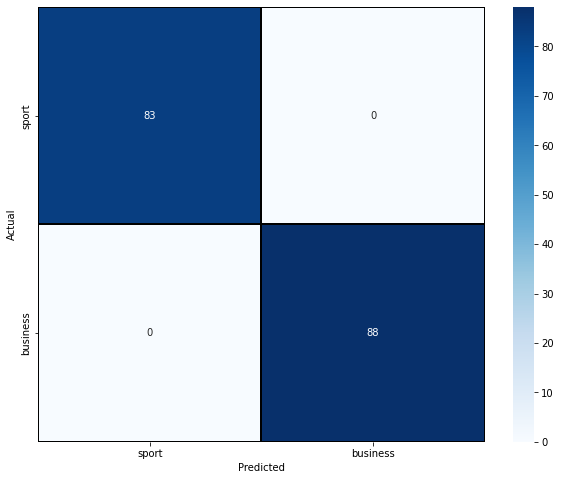

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
!pip install plot-metric --quiet

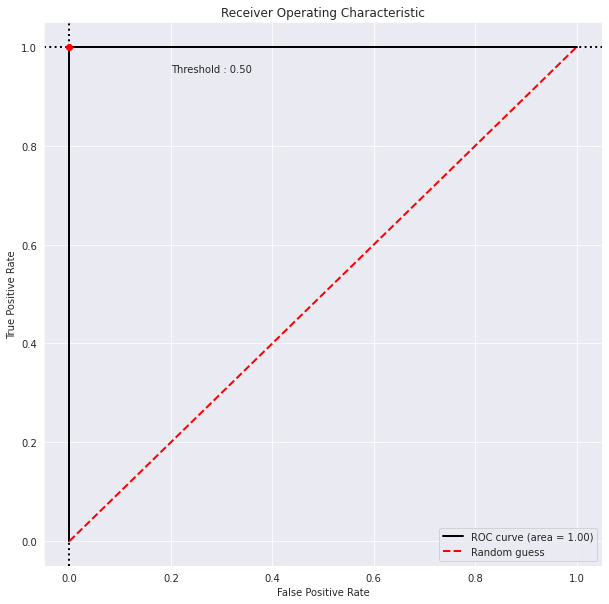

In [ ]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

In [ ]:
# X = features raw on text format
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [ ]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(y_test,predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  1.0


In [ ]:
test = pd.Series({'text':'i love football'})

In [ ]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Sport')
else:
  print('Business')

0
Sport


In [ ]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

#3b) Classificatore binario sport & politics